In [1]:
def make_monotonic(column_name, df):
    prev = df.loc[0, (column_name)]
    for i in range(1, len(df[column_name])):
        curr = df.loc[i, (column_name)]
        if curr < prev:
            df.loc[i, (column_name)] = prev
        prev = df.loc[i, (column_name)]
        
def calc_avg_clients_metrics(clients_metrics):
    avg_acc = 0
    avg_prec = 0
    avg_rec = 0
    avg_fscore = 0
    avg_loss = 0

    for client_metrics in clients_metrics:
        avg_acc += client_metrics["accuracy"]
        avg_prec += client_metrics["precision"]
        avg_rec += client_metrics["recall"]
        avg_fscore += client_metrics["f1"]
        avg_loss += client_metrics["loss"]
    
    nr_clients = len(clients_metrics)
    avg_acc /= nr_clients
    avg_prec /= nr_clients
    avg_rec /= nr_clients
    avg_fscore /= nr_clients
    avg_loss /= nr_clients

    return {
        'average_accuracy': avg_acc,
        'average_precision': avg_prec,
        'average_recall': avg_rec,
        'average_fscore': avg_fscore,
        'average_loss': avg_loss,
    }

No handles with labels found to put in legend.


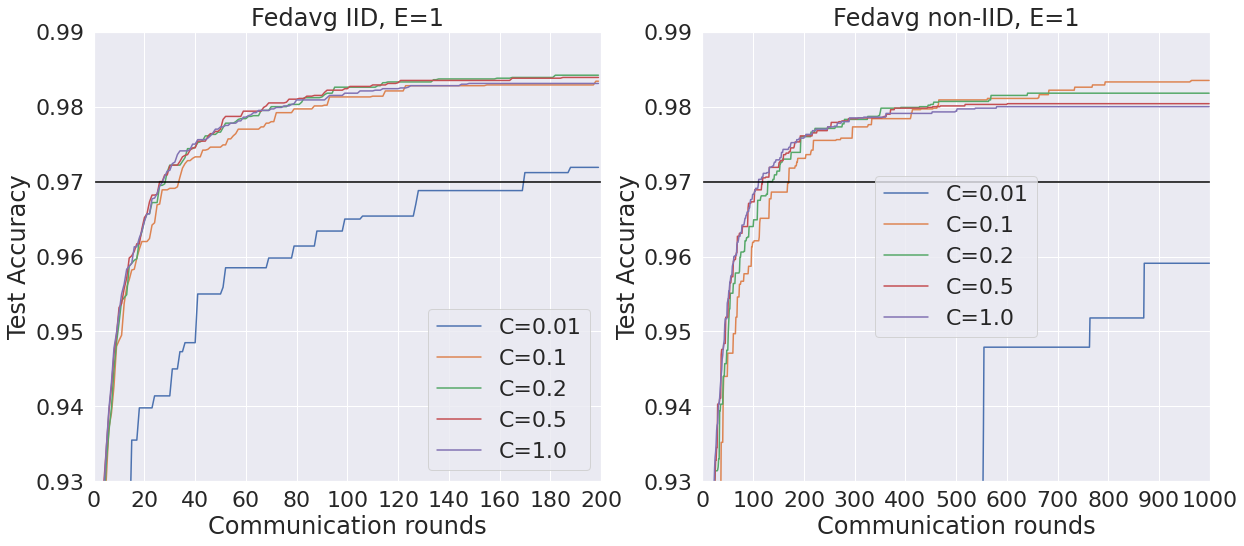

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all=[1, 10, 20, 50, 100]

dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 1   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    make_monotonic('accuracy', df)
    df["comm_round"] = [i for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
plt.legend(loc='upper left')
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('Fedavg IID, E=1')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 1   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    if C==1:
        communication_rounds = 4000
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    make_monotonic('accuracy', df)
    df["comm_round"] = [i for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
plt.xlim(0, 1000)
plt.ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('Fedavg non-IID, E=1')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
#graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.savefig("FedavgC.png")

# Fedavg E=10

No handles with labels found to put in legend.


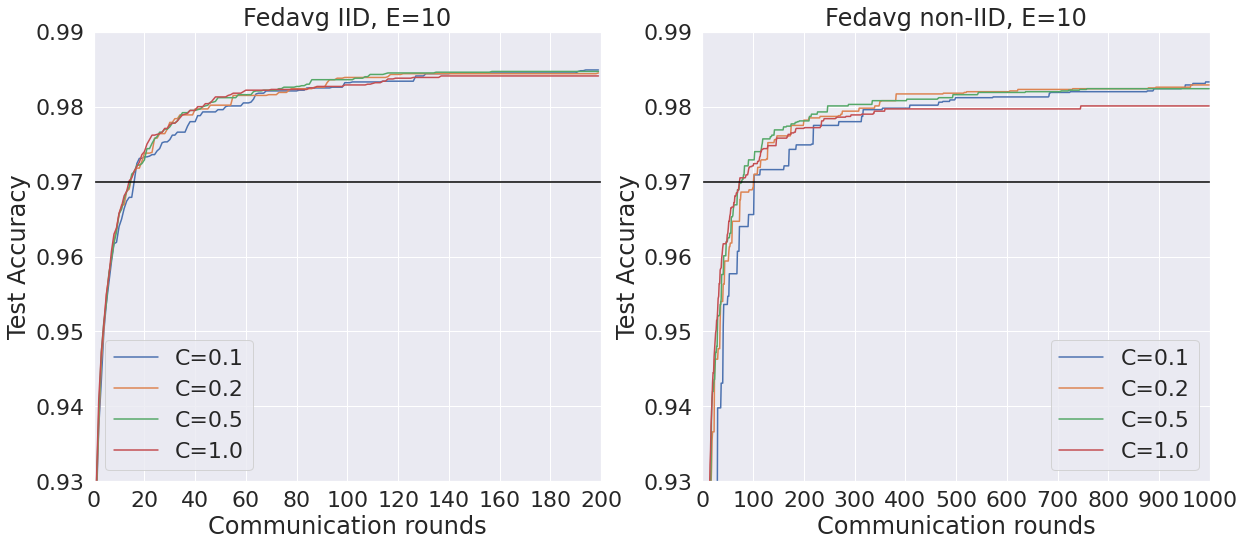

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.ticker as ticker
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

C_all= [10, 20, 50, 100]

dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 10   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    make_monotonic('accuracy', df)
    df["comm_round"] = [i for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
fig, ax = plt.subplots(1,2)
plt.legend(loc='upper left')
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[0])
graph.axhline(0.97, color='black')
graph.legend(handles=handles[:], labels=labels[:])
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(20))
graph.set_title('Fedavg IID, E=10')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')


dfs = []
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 10   # Number of client epochs
    communication_rounds = 1000  # Number of maximum communication rounds
    if C==1:
        communication_rounds = 4000
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_non_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    df = pd.DataFrame.from_dict(metrics[0])
    df.drop(columns=["classification_report"])
    make_monotonic('accuracy', df)
    df["comm_round"] = [i for i in range(communication_rounds)]
    df['sent_models_per_client'] = [i+1 for i in range(communication_rounds)]
    df['network_load'] = [(i+1)*(C*2) for i in range(communication_rounds)]
    dfs.append(df.assign(Clients="C={}".format(C/100)))

concatenated = pd.concat(dfs)
graph = sns.lineplot(x="comm_round", y="accuracy", hue="Clients", data=concatenated, ax=ax[1])
graph.axhline(0.97, color='black')
plt.xlim(0, 1000)
plt.ylim(0.93, 0.99)
graph.xaxis.set_major_locator(ticker.MultipleLocator(100))
graph.set_title('Fedavg non-IID, E=10')
graph.set_xlabel('Communication rounds')
graph.set_ylabel('Test Accuracy')

# Remove legend
handles, labels = graph.get_legend_handles_labels()
graph.legend(handles=handles[:], labels=labels[:])
#graph.xaxis.set_major_formatter(ticker.ScalarFormatter())
fig.savefig("FedavgCE1.png")

# Reach threshhold

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # *crazy big

### OPEN P2P
C_all=[10, 20, 50, 100]
dfs = []

# Key: C
# Value: per client communication
# when reached 97%
reach_threshhold = {'C': [], 'sent_models_per_client': [], 'network_load': [], 'comm_round': []}
for C in C_all:
    nr_clients = 100 ### NUMBER OF CLIENTS/ENTITIES
    client_epochs = 10   # Number of client epochs
    communication_rounds = 200  # Number of maximum communication rounds
    test_every_x_round = 1

    dir_str = '{}_{}_{}_{}_{}/'.format(nr_clients, C, client_epochs, communication_rounds, test_every_x_round)
    path = './Results/Fedavg_iid/' + dir_str

    with open(path + 'metrics', 'rb') as metrics_file:
        metrics = pickle.load(metrics_file)

    # per node communication
    # C*nr_clients*round
    all_rounds = metrics[0]
    # Find when acc bigger than 97%
    for i, test_round in enumerate(all_rounds):
        if test_round['accuracy'] >= 0.97:
            reach_threshhold['C'].append(C)
            reach_threshhold['sent_models_per_client'].append((i+1)*test_every_x_round*C)
            reach_threshhold['comm_round'].append((i+1)*test_every_x_round)
            reach_threshhold['network_load'].append((i+1)* test_every_x_round*nr_clients*C)
            break

print(reach_threshhold)
# df = pd.DataFrame(reach_threshhold)
# graph = sns.lineplot(x="neighbors", y="comm_round", data=df)
# graph.set_title("Reached average 97% f1score P2P models IID")

{'C': [10, 20, 50, 100], 'sent_models_per_client': [170, 320, 800, 1500], 'network_load': [17000, 32000, 80000, 150000], 'comm_round': [17, 16, 16, 15]}
